In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# ! scp -r arnab_sen_sharma@compute.safe.ai:/data/arnab_sen_sharma/Projects/relations/results ../../

In [4]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [5]:
############################################
sweep_root = "../../results/sweep-emb"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [6]:
from src.sweeps import (
    SweepRelationResults,
    SweepTrialResults,
    SweepLayerResults,
    SweepTrainResults,
    SweepBetaResults, SweepRankResults,
)

def parse_results(sweep_result):
    relation_results = SweepRelationResults(
        relation_name=sweep_result["relation_name"],
        trials = []
    )

    for trial in sweep_result["trials"]:
        trial_results = SweepTrialResults(
            prompt_template=trial["prompt_template"],
            train_samples=trial["train_samples"],
            layers = []
        )
        for layer in trial["layers"]:
            train_results = SweepTrainResults(
                samples = layer["result"]["samples"],
                betas = [],
                ranks = [],
                jh_norm=layer["result"]["jh_norm"],
            )
            for beta in layer["result"]["betas"]:
                beta_results = SweepBetaResults(
                    beta = beta["beta"],
                    recall = beta["recall"]
                )
                train_results.betas.append(beta_results)

            for rank in layer["result"]["ranks"]:
                rank_results = SweepRankResults(
                    rank = rank["rank"],
                    efficacy = rank["efficacy"]
                )
                train_results.ranks.append(rank_results)
            
            layer_results = SweepLayerResults(
                layer=layer["layer"],
                result=train_results
            )

            trial_results.layers.append(layer_results)
        relation_results.trials.append(trial_results)
    return relation_results

In [7]:
def plot_layerwise(canvas, relation_result, attribute = "recall", best_criterion = "faithfulness"):
    by_layer = relation_result.by_layer()

    layers = by_layer.keys()
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    canvas.scatter([best_layer.layer], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color='darkblue', linewidth=2)
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color='lightblue', alpha=0.5)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    canvas.set_title(f"{relation_result.relation_name} \n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

In [8]:
sweep_results = {}

for relation_folder in os.listdir(sweep_path):
    cur_sweep = f"{sweep_path}/{relation_folder}"
    if len(os.listdir(cur_sweep)) < 3:
        continue
    with open(f"{cur_sweep}/results_all.json") as f:
        res = json.load(f)["relations"]
        if(len(res) == 0):
            continue
        res = res[0]
        sweep_results[res["relation_name"]] = res

In [13]:
dataset = data.load_dataset()
all_relations = [
    relation.name for relation in dataset.relations
]
all_relations = sorted(all_relations)
# all_relations
failed_relations = list(set(all_relations) - set(sweep_results.keys()))
failed_relations = sorted(failed_relations)
failed_relations

['characteristic gender',
 'company hq',
 'fruit inside color',
 'fruit outside color',
 'landmark in country',
 'landmark on continent',
 'name religion',
 'occupation age',
 'person father',
 'person native language',
 'plays pro sport',
 'product by company',
 'univ degree gender',
 'word first letter',
 'word last letter']

/tmp/ipykernel_387991/279396172.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


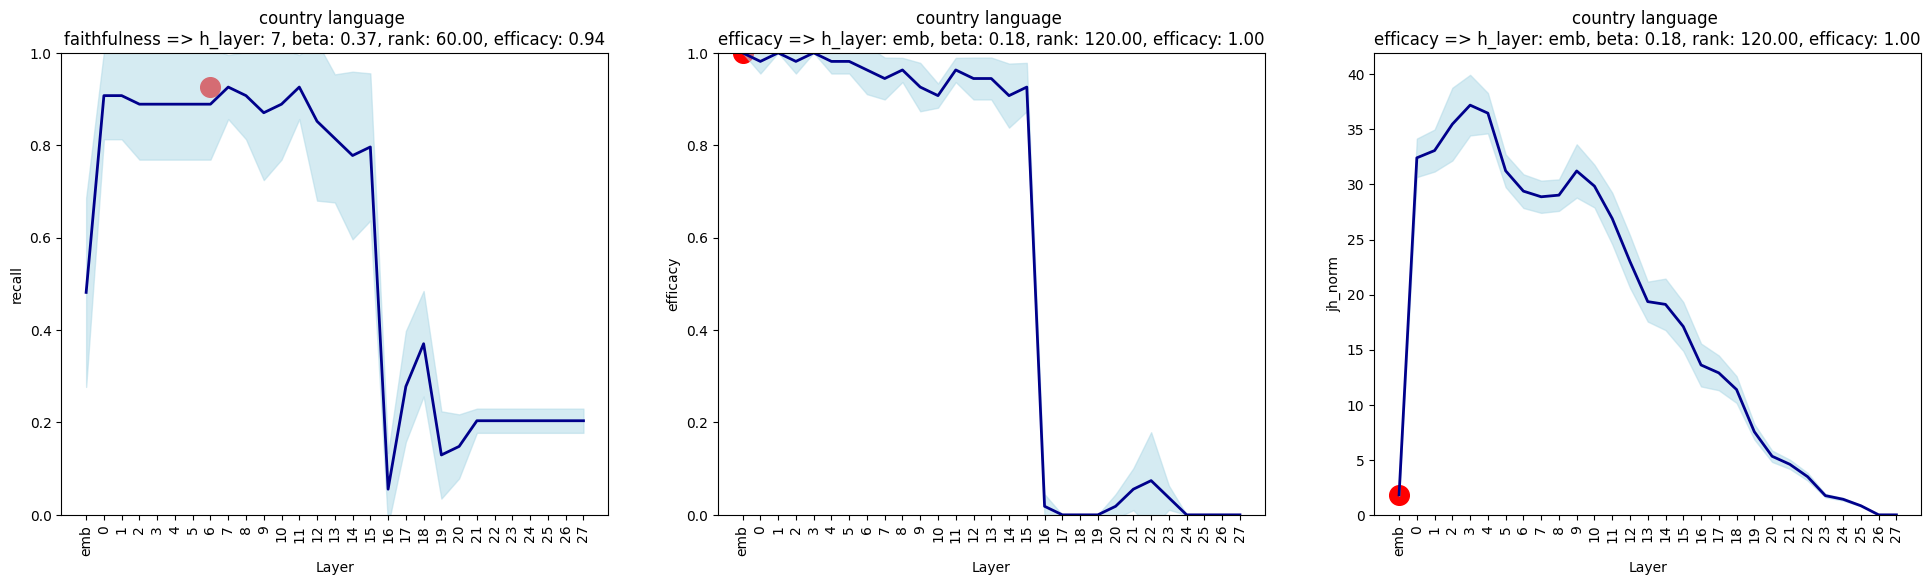

In [144]:
relation_result = parse_results(sweep_results['country language'])

nrows = 1
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))

plot_layerwise(ax[0], relation_result)
plot_layerwise(ax[1], relation_result, attribute="efficacy", best_criterion="efficacy")
plot_layerwise(ax[2], relation_result, attribute="jh_norm", best_criterion="efficacy")

fig.show()

In [145]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation in interested_dataset.relations:
    if relation.name not in sweep_results:
        continue
    filtered_results[relation.name] = parse_results(sweep_results[relation.name])

/tmp/ipykernel_387991/3555244666.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


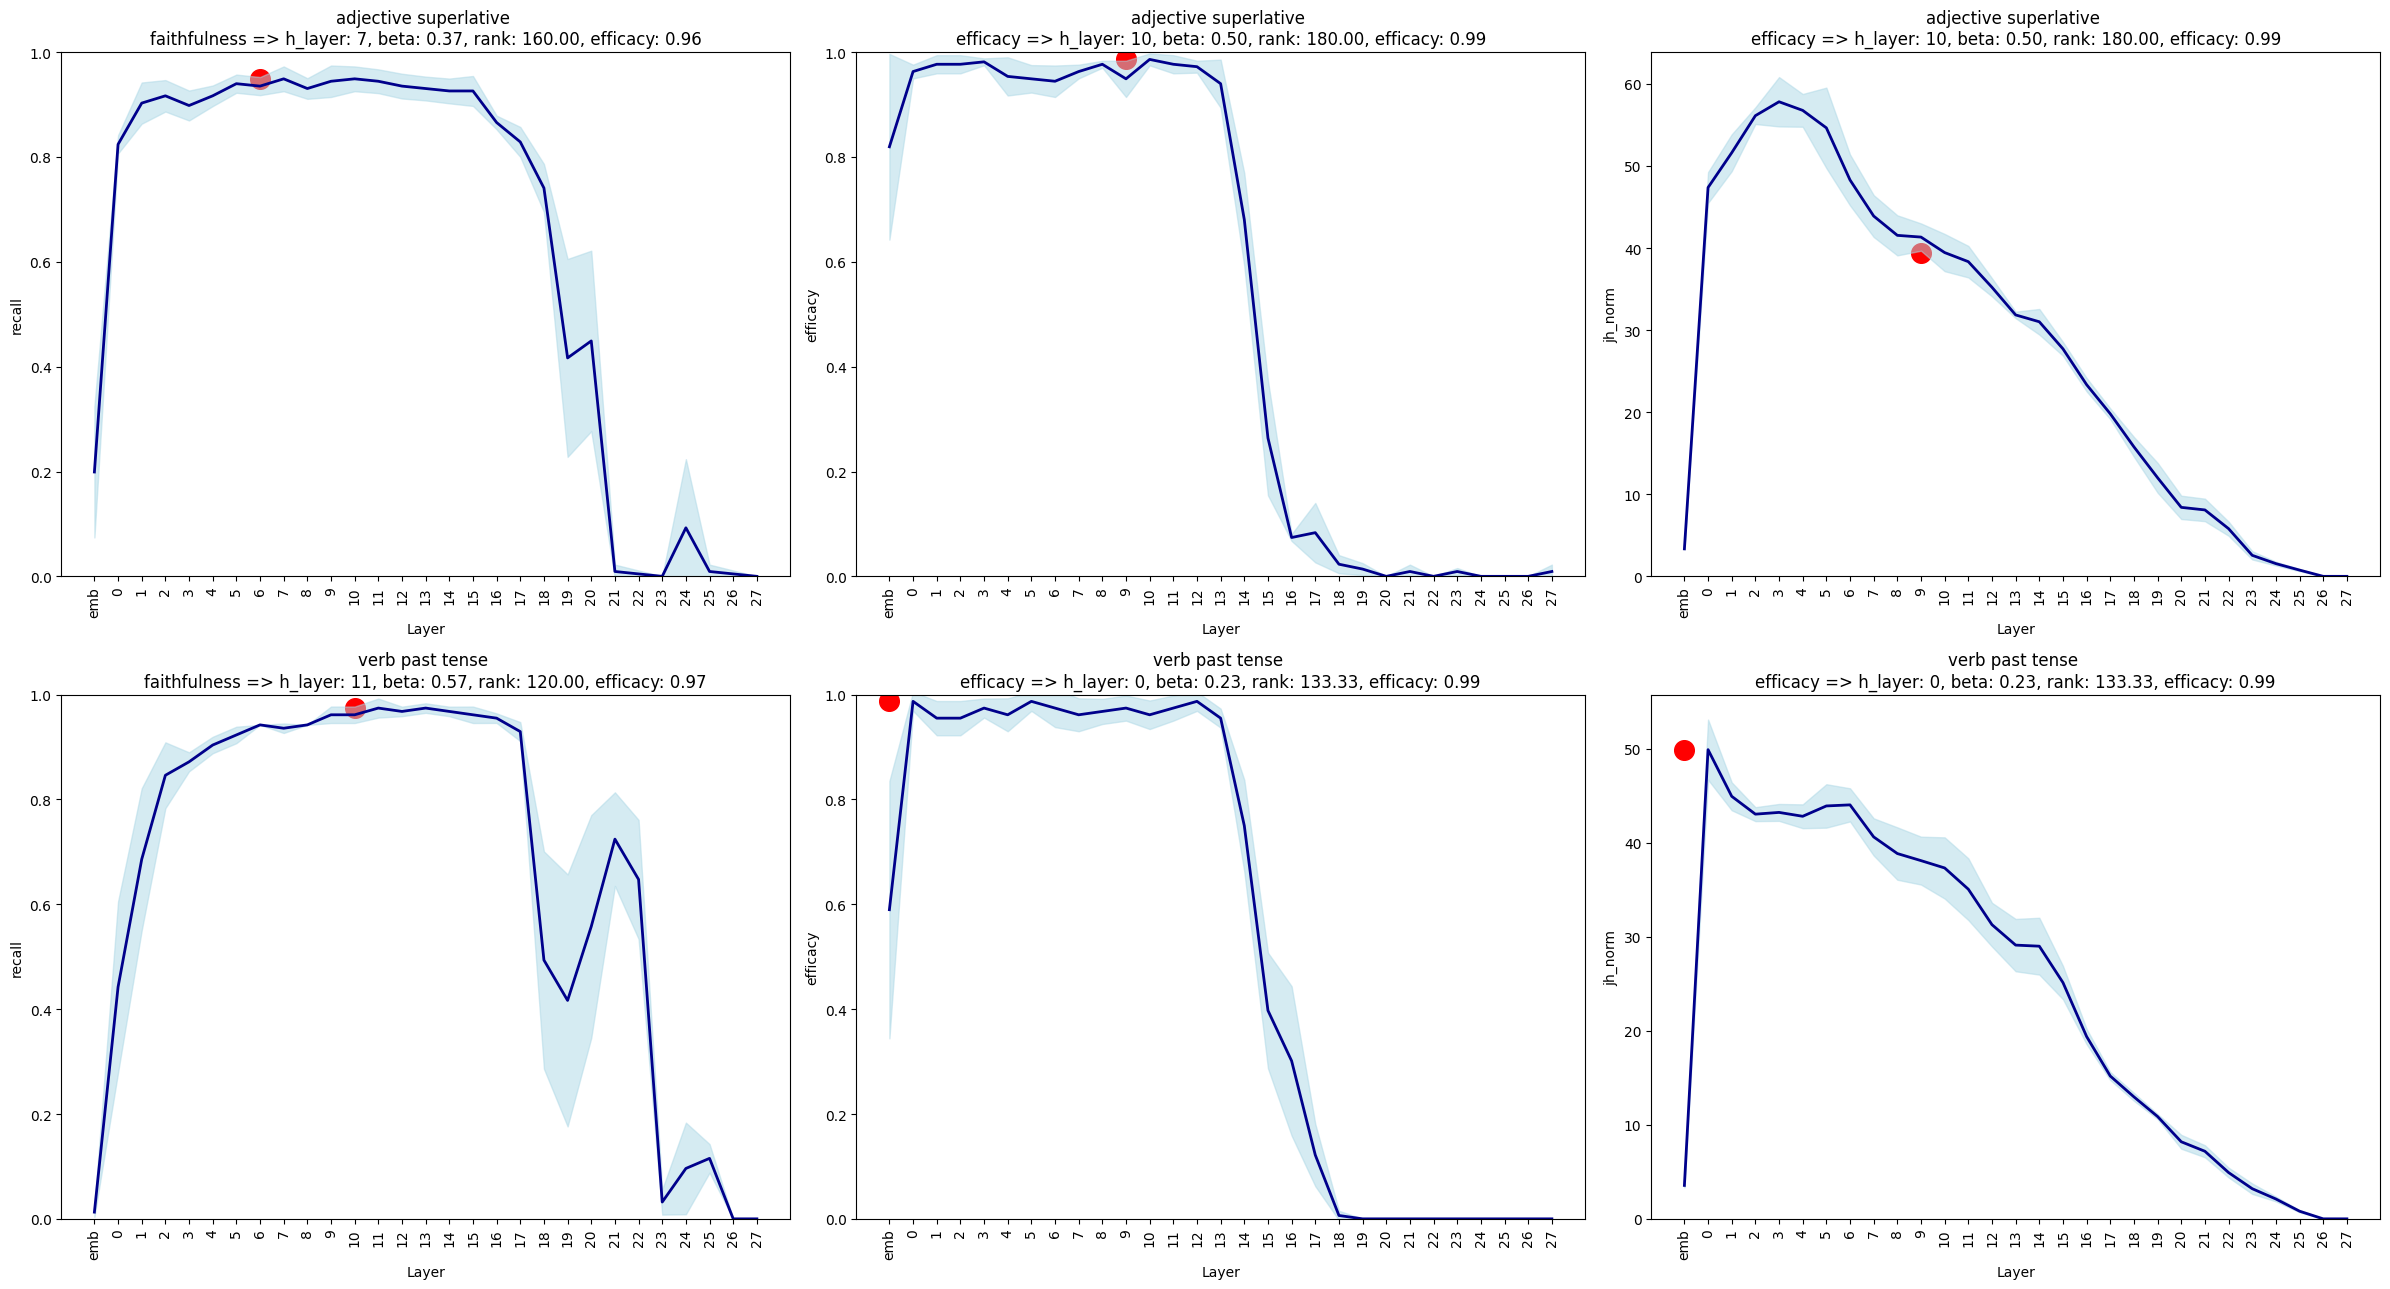

In [163]:
# n_subplots = len(filtered_results) * 3
n_subplots = 2  * 3
ncols=3
nrows=int(np.ceil(n_subplots/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
if n_subplots == 1:
    axes = [axes]

ax_col, ax_row = 0, 0
for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[30:]:
    result = parse_results(sweep_results[relation_name])
    plot_layerwise(axes[ax_row][0], result)
    plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
    plot_layerwise(axes[ax_row][2], result, attribute="jh_norm", best_criterion="efficacy")
    ax_row += 1
    # break
fig.tight_layout()
fig.show()

In [34]:
def plot_betawise(canvas, relation_result, recall_at = 1):
    best_layer = result.best()

    beta_recalls = {}
    for trial in relation_result.trials:
        layer = trial.layers[best_layer.layer]
        for beta in layer.result.betas:
            if beta.beta not in beta_recalls:
                beta_recalls[beta.beta] = []
            beta_recalls[beta.beta].append(beta.recall)
    for beta in beta_recalls:
        beta_recalls[beta] = np.array(beta_recalls[beta]).mean(axis = 0)

    betas = list(beta_recalls.keys())
    recalls = [
        beta_recalls[beta][recall_at-1]
        # beta_recalls[beta].mean() 
        for beta in betas
    ]
    canvas.plot(betas, recalls, color='darkblue', linewidth=2)
    canvas.vlines(best_layer.beta.mean, 0, 1, color="darkred", linewidth=2)

    canvas.set_ylim(0, 1)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel("Recall")
    canvas.set_xticks(betas, [np.round(b, 2) for b in betas], rotation=90)
    canvas.set_title(f"{relation_result.relation_name} | h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}")
    
    return canvas

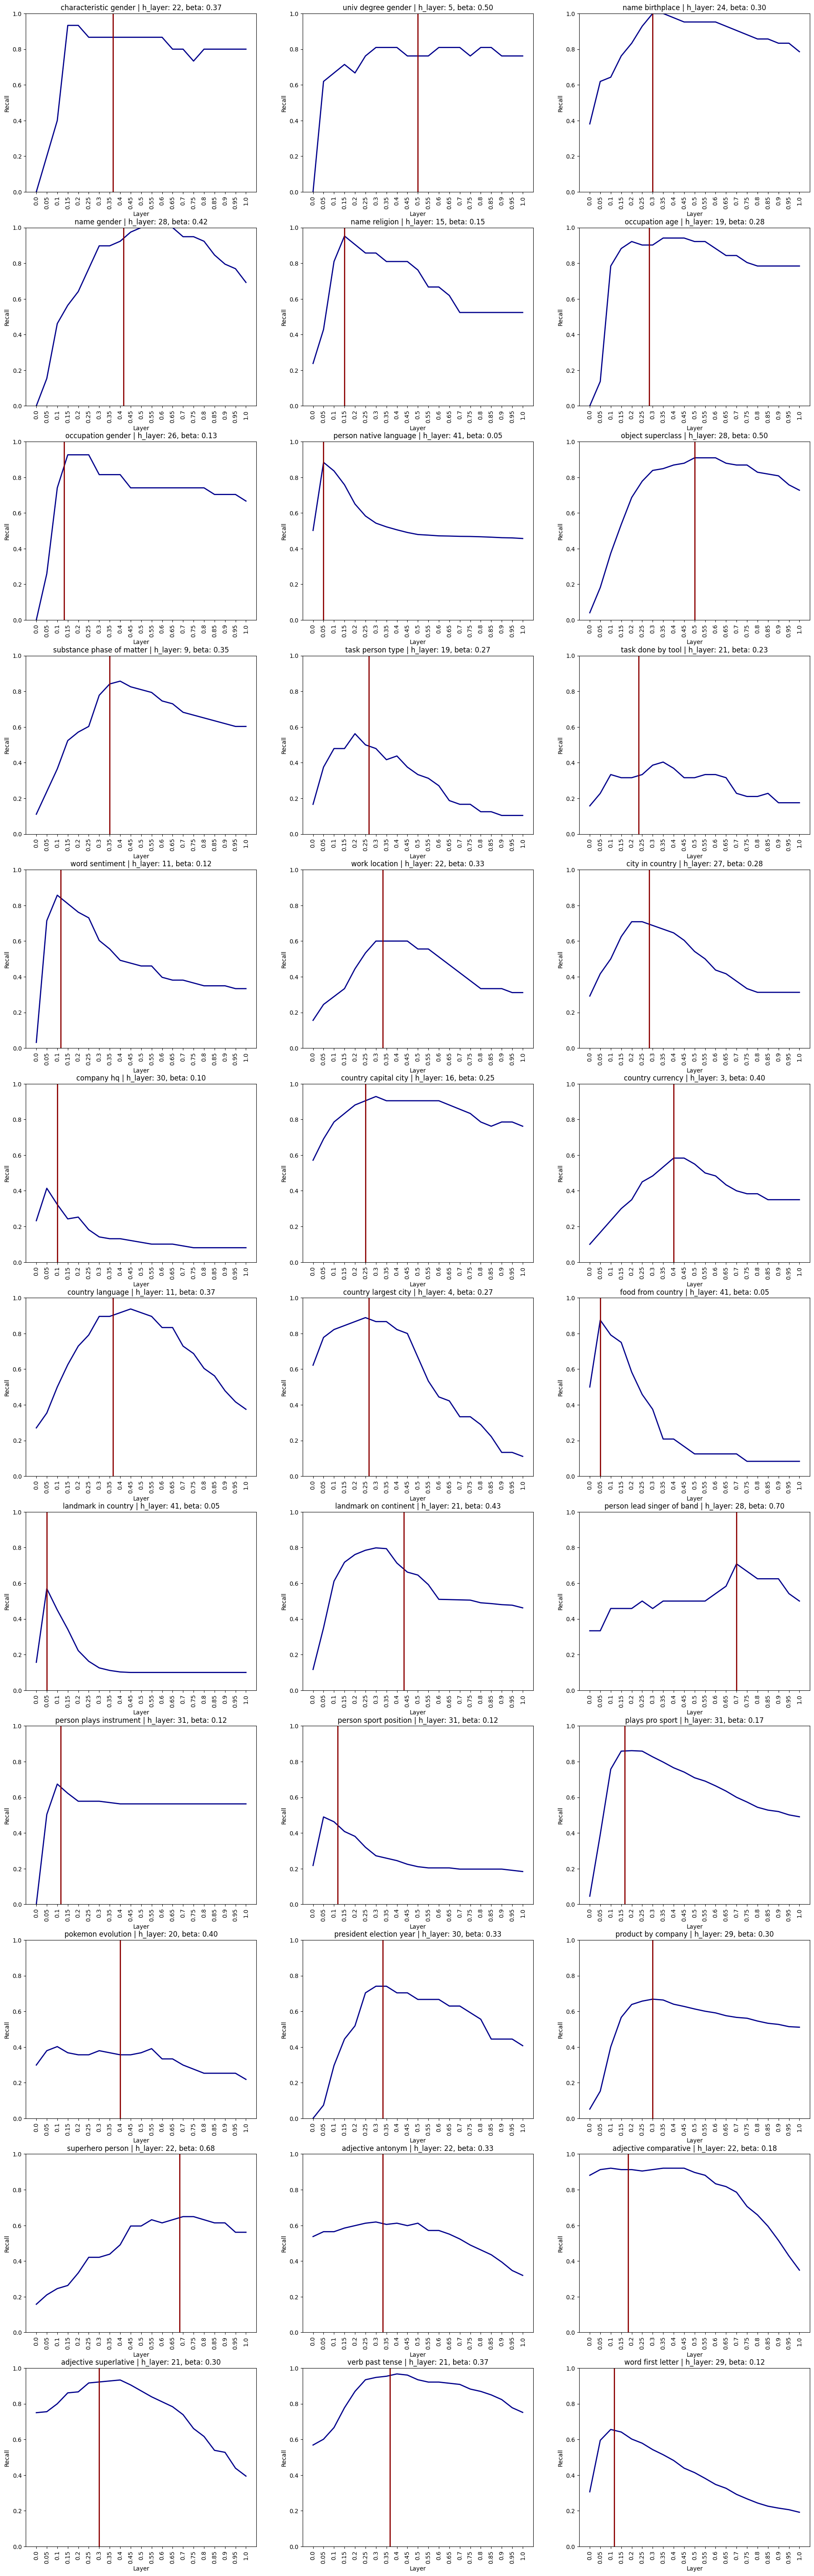

In [35]:
n_subplots = len(filtered_results)
ncols=3
nrows=int(np.ceil(n_subplots/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
if n_subplots == 1:
    axes = [axes]

ax_col, ax_row = 0, 0
for i, (relation_name, relation_result) in enumerate(filtered_results.items()):
    result = parse_results(sweep_results[relation_name])
    plot_betawise(axes[ax_row][ax_col], relation_result)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
fig.show()

In [36]:
result.best()

SweepFaithfulnessLayerSummary(layer=29, beta=AggregateMetric(mean=0.11666666964689891, stdev=0.02357022814689401, stderr=0.013608277565470152, values=[0.15000000596046448, 0.10000000149011612, 0.10000000149011612]), recall=AggregateMetric(mean=0.6577060931899642, stdev=0.002534432907478663, stderr=0.001463255521375852, values=[0.6612903225806451, 0.6559139784946236, 0.6559139784946236]))